In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

import re

from Utilities.EvaluationMain import *
from Utilities.Utilities import ReadYaml, SerializeObjects, DeserializeObjects
from Models.Caller import *
from BatchMIEvaluation import LoadModelConfigs, LoadParams
from Utilities.Visualization import VisReconGivenZ_FCA, HeatMapFreqZ_FCA, VisReconGivenFC_ZA, VisReconExtractZ_FC


In [2]:
def extract_dimension(model):
    match = re.search(r'\d{2}', model)
    return match[0] if match else None

def add_underbrace(ax, center, text, width=2.0, height=0.2, y_offset=-0.15):
    """
    Adds an 'underbrace' outside the plot axes.

    Parameters:
    - ax: The axis object to add the underbrace to.
    - center: The center x position of the underbrace.
    - text: The label text to place under the underbrace.
    - width: The width of the underbrace.
    - height: The height of the underbrace.
    - y_offset: The y-axis offset for the underbrace and text.
    """
    # Create an arc (i.e., the underbrace)
    arc = patches.Arc((center, y_offset), width=width, height=height, angle=0,
                      theta1=180, theta2=0, color='black', lw=1.5)
    
    # Disable clipping (so the arc can be drawn outside the axes)
    arc.set_clip_on(False)
    ax.add_patch(arc)
    
    # Add the label text under the arc, disable clipping
    text_artist = ax.text(center, y_offset - (height / 2)-0.02, text, ha='center', va='top', fontsize=14)
    text_artist.set_clip_on(False)


### Aggregation of Mutual Information Tables for Model Evaluation

In [3]:
# Retrieve and filter Mutual Information (MI) table names from directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI_' in tab and 'Nj1_' in tab and 'FC1.0' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI_' in tab and 'Nj1.' in tab]

# Initialize DataFrames and concatenate tables for MI datasets
MItableSet = pd.DataFrame()
for tab in MItableList:
    MItables = pd.read_csv('./EvalResults/Tables/' + tab)
    MItableSet = pd.concat([MItableSet, MItables], axis=0)

BMMItableSet = pd.DataFrame()
for tab in BMMItableList:
    MItables = pd.read_csv('./Benchmarks/EvalResults/Tables/' + tab)
    BMMItableSet = pd.concat([BMMItableSet, MItables], axis=0)

# Combine MI tables from main and benchmark sets
MItableSet = pd.concat([MItableSet, BMMItableSet])



# Retrieve accuracy table names from specific directories
# Filter tables containing 'Acc' and 'Nj1_' in their names from both directories
AcctableList = [tab for tab in TableList if 'AccKLD' in tab and 'Nj1_' in tab and 'FC1.0' in tab]
BMAcctableList = [tab for tab in BMtableList if 'AccKLD' in tab and 'Nj1.' in tab]

# Initialize DataFrames for storing accuracy tables from main and benchmark datasets
AcctableSet = pd.DataFrame()
BMAcctableSet = pd.DataFrame()

# Read and concatenate accuracy tables from the main dataset
for tab in AcctableList:
    Acctables = pd.read_csv('./EvalResults/Tables/' + tab)
    AcctableSet = pd.concat([AcctableSet, Acctables], axis=0)

# Read and concatenate accuracy tables from the benchmark dataset
for tab in BMAcctableList:
    Acctables = pd.read_csv('./Benchmarks/EvalResults/Tables/' + tab)
    BMAcctableSet = pd.concat([BMAcctableSet, Acctables], axis=0)


# Combine accuracy tables from both main and benchmark datasets
AcctableSet = pd.concat([AcctableSet, BMAcctableSet])
AcctableSetLong = pd.melt(AcctableSet, id_vars=['Model'], value_vars=['MeanKldRes', 'MAPEnorm'])
AcctableSetLong = AcctableSetLong.rename(columns={'variable':'Metrics', 'value':'Values'})
MetricRename = {'MeanKldRes' : '(8) FQI', 'MAPEnorm' :'(7) MAPE' }
AcctableSetLong['Metrics'] = AcctableSetLong['Metrics'].map(MetricRename)

AccMItab = pd.concat([MItableSet, AcctableSetLong]).reset_index(drop=True)

### Model Data Preparation and Renaming 

In [4]:
# Define lists of table names for ART and II categories
ARTTabList = ['BaseVAE_ART_30',   'ConVAE_ART_30', 'SKZ_ART_30_500', 'SKZ_ART_30_800', 'SKZFC_ART_30_500', 'SKZFC_ART_30_800',   'TCVAE_ART_30', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_30_800',   'FACVAE_ART_30', 'FACFC_ART_30_500', 'FACFC_ART_30_800',
              'BaseVAE_ART_50',   'ConVAE_ART_50', 'SKZ_ART_50_500', 'SKZ_ART_50_800', 'SKZFC_ART_50_500', 'SKZFC_ART_50_800',   'TCVAE_ART_50', 'TCMIDKZFC_ART_50_500', 'TCMIDKZFC_ART_50_800',   'FACVAE_ART_50', 'FACFC_ART_50_500', 'FACFC_ART_50_800']

IITabList = ['BaseVAE_II_30',   'ConVAE_II_30', 'SKZ_II_30_500', 'SKZ_II_30_800', 'SKZFC_II_30_500', 'SKZFC_II_30_800',   'TCVAE_II_30', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_30_800',   'FACVAE_II_30', 'FACFC_II_30_500', 'FACFC_II_30_800',
             'BaseVAE_II_50',   'ConVAE_II_50', 'SKZ_II_50_500', 'SKZ_II_50_800', 'SKZFC_II_50_500', 'SKZFC_II_50_800',   'TCVAE_II_50', 'TCMIDKZFC_II_50_500', 'TCMIDKZFC_II_50_800',   'FACVAE_II_50', 'FACFC_II_50_500', 'FACFC_II_50_800']


# Define a list of analytical metrics
AnalMetricList = ['(7) MAPE', '(8) FQI', '(i) I(V;Z)', '(ii) $I(V; \\acute{Z} \\mid Z)$']

# Initialize a dictionary for renaming models
ModelRename = {}
for model in MItableSet['Model'].unique():
    # Create a new model name based on specific patterns in the model string
    if bool(re.search('_\d{3}', model)):
        ModelRename[model] = model[:-6]  + model[-3:-2] + 's'
    else:
        ModelRename[model] = model[:-3] 

    # Special renaming condition for models containing 'Base'
    if 'Base' in model:
        ModelRename[model] = 'B-VAE_' +  ModelRename[model].split('_')[1]

        

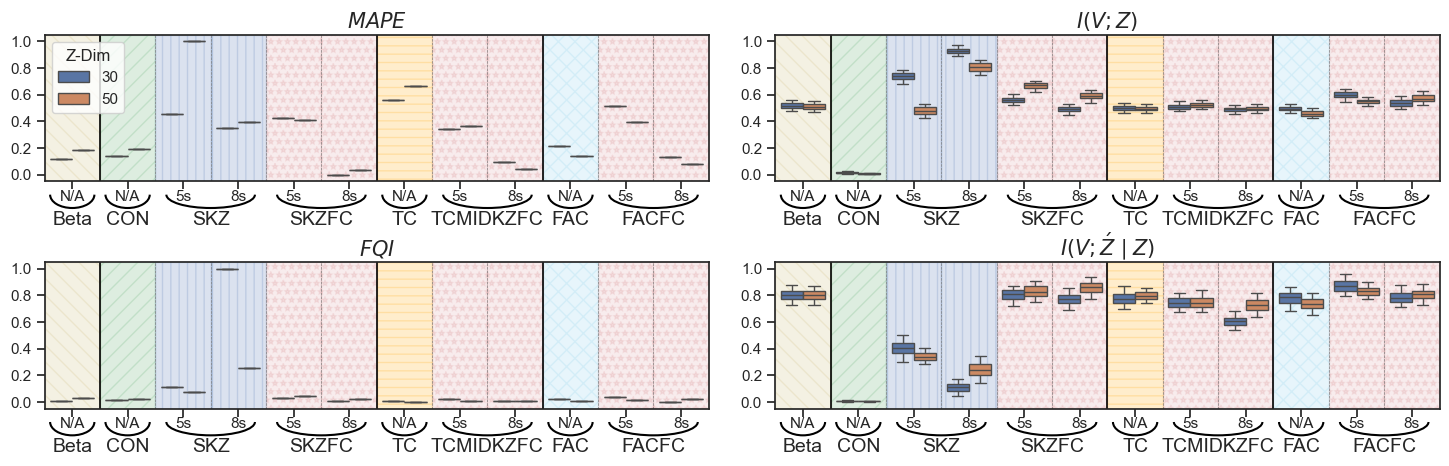

In [6]:
# Set the table list for analysis and determine the NZ (New Zealand) list based on the first item in the list
AnalTabList = ARTTabList  # Change to IITabList or ARTTabList as needed

# Filter the MI table set for analysis based on the specified tables and metrics
AnaltableSet = AccMItab[(AccMItab['Model'].isin(AnalTabList)) & (AccMItab['Metrics'].isin(AnalMetricList))].reset_index(drop=True).copy()
AnaltableSet['MetricNew'] = AnaltableSet['Metrics'].str.replace(r'\(\w+\)\s*', '', regex=True)

MetricRename2 = {'I(V;Z)' : '$I(V;Z)$', 'MAPE' : '$MAPE$', 'FQI':'$FQI$', '$I(V; \\acute{Z} \\mid Z)$':'$I(V; \\acute{Z} \\mid Z)$' }
AnaltableSet['MetricNew'] = AnaltableSet['MetricNew'].map(MetricRename2)

AnaltableSet['Values'] = AnaltableSet.groupby('Metrics')['Values'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
metrics_categories = ['$MAPE$','$FQI$', '$I(V;Z)$', '$I(V; \\acute{Z} \\mid Z)$']

# Rename models in the analysis table set and update the table list
AnaltableSet['Z-Dim'] = AnaltableSet['Model'].apply(extract_dimension)
AnaltableSet['Model'] = AnaltableSet['Model'].map(ModelRename)

# Create a unique list 'UniqAnalTabList' that contains only the first occurrence of each item.
AnalTabList = [ModelRename[item] if item in ModelRename else item for item in AnalTabList]
UniqAnalTabList = []
seen = set()
for item in AnalTabList:
    if item not in seen:
        UniqAnalTabList.append(item)
        seen.add(item)

# Create model labels and a dictionary for mapping models to these labels
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ModelLabels = [f'${letter}$' for letter in alphabet[:len(AnalTabList)]]
DictModelLabel = {model: f'${alphabet[i]}$' for i, model in enumerate(UniqAnalTabList)}

# Sort the DataFrame based on a created sorting key
AnaltableSet['SortKey'] = AnaltableSet['Model'].map(DictModelLabel)
AnaltableSet = AnaltableSet.sort_values(by='SortKey').drop(columns=['SortKey'])

# Prepare for violin plot visualization
global_min = AnaltableSet['Values'].min()
global_max = AnaltableSet['Values'].max()
total_models = len(AnalTabList)
fixed_palette = sns.color_palette("Set2", total_models)

# Set up seaborn style
sns.set(style="ticks")

# Create 2x2 subplots for each metric category
fig, axes = plt.subplots(2, 2, figsize=(18, 5.5))  # Adjust the figure size as needed
axes = axes.flatten(order='F')  # Flatten the 2D array of axes into 1D for easy iteration

PlotIdx = 0
# Plotting logic for each subplot
for i, metric in enumerate(metrics_categories):
    ax = axes[i]
    Subset = AnaltableSet[AnaltableSet['MetricNew'] == metric]

    # Sort models alphabetically based on the labels
    unique_models_subset = sorted(Subset['Model'].unique(), key=lambda x: DictModelLabel.get(x, ''))
    NumModels = len(unique_models_subset)

    for num, line_pos in enumerate ([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5 ]):
        if num in [0,  5, 8]:
            ax.axvline(x=line_pos, color='black', linestyle='-', linewidth=1.2)
        else:
            ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.5)

        if 'B-VAE' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='y', alpha=0.2, hatch='\\\\', edgecolor='y')
        elif  'ConVAE_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='g', alpha=0.2, hatch='//', edgecolor='g')
        elif  'TCVAE_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='orange', alpha=0.2, hatch='--', edgecolor='orange')
        elif  'FACVAE_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='skyblue', alpha=0.2, hatch='xx', edgecolor='skyblue')
        elif  'SKZ_' in unique_models_subset[num]:
            ax.axvspan(line_pos-1., line_pos, facecolor='b', alpha=0.2, hatch='||', edgecolor='b')
        else:
            ax.axvspan(line_pos-1., line_pos, facecolor='r', alpha=0.1, hatch='**', edgecolor='r')
        
    sns.boxplot(x='Model', y='Values', hue='Z-Dim', data=Subset, ax=ax, showfliers=False, whis=[5, 95], hue_order=['30', '50'])

    if i == 0:
        # 첫 번째 plot에만 범례 표시
        ax.legend(title='Z-Dim',  loc='upper left')
    else:
        # 나머지 plot에서는 범례 제거
        ax.legend([], frameon=False)
        
    
    if 'ART' in AnaltableSet['Model'][0]: 
        y_offset = -0.15
    else: 
        y_offset = -0.15
    
    # Add underbraces with the function
    add_underbrace(ax, 0, 'Beta', width=0.8, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 1., 'CON', width=0.8, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 2.5, 'SKZ', width=1.6, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 4.5, 'SKZFC', width=1.6, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 6., 'TC', width=0.8, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 7.5, 'TCMIDKZFC', width=1.6, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 9., 'FAC', width=0.8, height=0.2 ,y_offset=y_offset)
    add_underbrace(ax, 10.5, 'FACFC', width=1.6, height=0.2 ,y_offset=y_offset)
        
    ax.set_title(metric , fontsize=15, pad=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_xticks(range(NumModels))
    #ax.set_xticklabels([DictModelLabel[model] for model in unique_models_subset])
    ax.set_xticklabels('')

    ax.set_ylim([-0.05, 1.05])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    PlotIdx += 1

    ax.text(0, -0.11, 'N/A', ha='center', va='top', fontsize=11)
    ax.text(1, -0.11, 'N/A', ha='center', va='top', fontsize=11)
    ax.text(6, -0.11, 'N/A', ha='center', va='top', fontsize=11)
    ax.text(9, -0.11, 'N/A', ha='center', va='top', fontsize=11)
    
    for num, line_pos in enumerate ([2, 4, 7,10]):
        ax.text(line_pos, -0.11, '5s', ha='center', va='top', fontsize=11)
        ax.text(line_pos+1, -0.11, '8s', ha='center', va='top', fontsize=11)

# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.1, hspace=0.55)

# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])



if 'ART' in AnaltableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/Metric_ART1.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/Metric_II1.png', bbox_inches='tight')

plt.show()


### Tabulating for result check

In [7]:
# Group the MI table set by 'Model' and 'MetricNew', calculate the mean, and reset the index
AnalMItableEval = AnaltableSet[['Model', 'MetricNew', 'Values', 'Z-Dim']].groupby(['Model', 'MetricNew', 'Z-Dim']).mean().reset_index().copy()
# Create a sorting key by mapping the 'Model' column through the DictModelLabel
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key and reset the index
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Drop the 'SortKey' column as it's no longer needed
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])

# Display the final DataFrame
AnalMItableEval 
sorted_labels

[('B-VAE_ART', '$A$'),
 ('ConVAE_ART', '$B$'),
 ('SKZ_ART_5s', '$C$'),
 ('SKZ_ART_8s', '$D$'),
 ('SKZFC_ART_5s', '$E$'),
 ('SKZFC_ART_8s', '$F$'),
 ('TCVAE_ART', '$G$'),
 ('TCMIDKZFC_ART_5s', '$H$'),
 ('TCMIDKZFC_ART_8s', '$I$'),
 ('FACVAE_ART', '$J$'),
 ('FACFC_ART_5s', '$K$'),
 ('FACFC_ART_8s', '$L$')]

### Comparison with ablation models 
#### Define lists of table names for different categories and conditions in ART and II

In [8]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800'] 


TabList_II = ['ConVAE_II_30', 'ConVAE_II_50',   'SKZ_II_30_500','SKZ_II_30_800', 'SKZ_II_50_500','SKZ_II_50_800',  
              'SKZFC_II_30_500', 'SKZFC_II_30_800', 'SKZFC_II_50_500', 'SKZFC_II_50_800',
              'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_500', 'TCMIDKZFC_II_50_800', 
              'FACFC_II_30_500', 'FACFC_II_30_800', 'FACFC_II_50_500', 'FACFC_II_50_800']

TabList_ART = ['ConVAE_ART_30', 'ConVAE_ART_50',   'SKZ_ART_30_500','SKZ_ART_30_800', 'SKZ_ART_50_500','SKZ_ART_50_800',  
              'SKZFC_ART_30_500', 'SKZFC_ART_30_800', 'SKZFC_ART_50_500', 'SKZFC_ART_50_800',
              'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_500', 'TCMIDKZFC_ART_50_800', 
              'FACFC_ART_30_500', 'FACFC_ART_30_800', 'FACFC_ART_50_500', 'FACFC_ART_50_800']

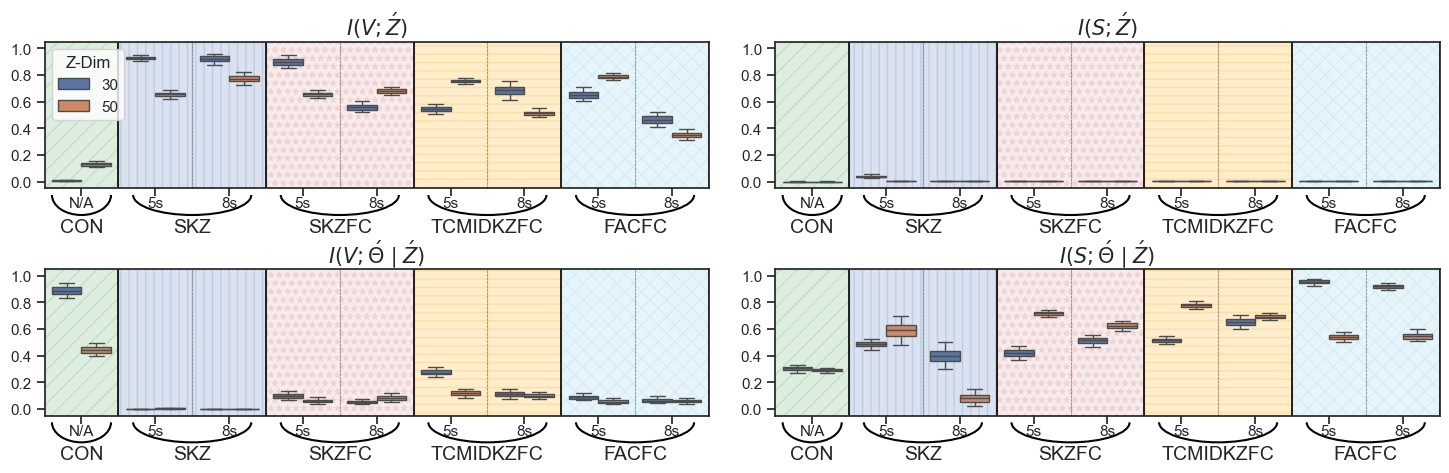

In [11]:
AnalTabList = TabList_II  # TabList_ART   TabList_II
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
AnalMItableSet['MetricNew'] = AnalMItableSet['Metrics'].str.replace(r'\(\w+\)\s*', '', regex=True)  # Extract new metric names
AnalMItableSet['Values'] = AnalMItableSet.groupby('Metrics')['Values'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
metrics_categories = AnalMItableSet['MetricNew'].unique()[2:]

# Rename models in the analysis table set and update the table list
AnalMItableSet['Z-Dim'] = AnalMItableSet['Model'].apply(extract_dimension)
AnalMItableSet['Model'] = AnalMItableSet['Model'].map(ModelRename)

# Retrieve unique values from the 'Metrics' column
alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ModelLabels = [f'${letter}$' for letter in alphabet[:len(AnalTabList)]]
AnalTabList = [ModelRename[item] if item in ModelRename else item for item in AnalTabList]

# Create a unique list 'UniqAnalTabList' that contains only the first occurrence of each item.
UniqAnalTabList = []
seen = set()
for item in AnalTabList:
    if item not in seen:
        UniqAnalTabList.append(item)
        seen.add(item)
        
DictModelLabel = {model: f"{ModelLabels[i]}" for i, model in enumerate(UniqAnalTabList)}

# Sort the DataFrame based on a created sorting key
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').drop(columns=['SortKey'])

# Prepare for violin plot visualization
global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()
total_models = len(AnalTabList)
fixed_palette = sns.color_palette("Set2", total_models)

# Set up seaborn style
sns.set(style="ticks")

# Create a 3x2 subplot structure
fig, axes = plt.subplots(2, 2, figsize=(18, 5.5))
axes = axes.flatten(order='F')

PlotIdx = 0
# Generate violin plots for each 'Metrics'
for ax, metric in zip(axes, metrics_categories):
    Subset = AnalMItableSet[AnalMItableSet['MetricNew'] == metric]

    # Sort models alphabetically based on the labels
    unique_models_subset = sorted(Subset['Model'].unique(), key=lambda x: DictModelLabel.get(x, ''))
    NumModels = len(unique_models_subset)
    palette = sns.color_palette("Set2", NumModels)

    for num, line_pos in enumerate ([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5 ]):
        if num in [0,  2, 4, 6, 8]:
            ax.axvline(x=line_pos, color='black', linestyle='-', linewidth=1.2)
        else:
            ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.5)

        
        if num in [0]:
            ax.axvspan(line_pos-1., line_pos, facecolor='g', alpha=0.2, hatch='//', edgecolor='g')
        elif  num in [1,2]:
            ax.axvspan(line_pos-1., line_pos, facecolor='b', alpha=0.2, hatch='||', edgecolor='b')
        elif  num in [3,4]:
            ax.axvspan(line_pos-1., line_pos, facecolor='r', alpha=0.1, hatch='**', edgecolor='r')
        elif  num in [5,6]:
            ax.axvspan(line_pos-1., line_pos, facecolor='orange', alpha=0.2, hatch='--', edgecolor='orange')
        elif  num in [7,8]:
            ax.axvspan(line_pos-1., line_pos, facecolor='skyblue', alpha=0.2, hatch='xx', edgecolor='skyblue')

    y_offset = - 0.1
    # Add underbraces with the function
    add_underbrace(ax, 0, 'CON', width=0.8, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 1.5, 'SKZ', width=1.6, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 3.5 , 'SKZFC', width=1.6, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 5.5, 'TCMIDKZFC', width=1.6, height=0.3 ,y_offset=y_offset)
    add_underbrace(ax, 7.5, 'FACFC', width=1.6, height=0.3 ,y_offset=y_offset)



    ax.text(0, -0.11, 'N/A', ha='center', va='top', fontsize=11)
    for num, line_pos in enumerate ([1, 3, 5,7]):
        ax.text(line_pos, -0.11, '5s', ha='center', va='top', fontsize=11)
        ax.text(line_pos+1, -0.11, '8s', ha='center', va='top', fontsize=11)
    
    
    sns.boxplot(x='Model', y='Values', hue='Z-Dim', data=Subset, ax=ax, showfliers=False, whis=[5, 95], hue_order=['30', '50'])

    if PlotIdx == 0:
        # 첫 번째 plot에만 범례 표시
        ax.legend(title='Z-Dim',  loc='upper left')
    else:
        # 나머지 plot에서는 범례 제거
        ax.legend([], frameon=False)

    '''
    if PlotIdx <= 1:
        ax.legend(title='Z-Dim',  loc='upper right')
    else:
        ax.legend(title='Z-Dim',  loc='upper left')
    '''
    
    ax.set_title(metric , fontsize=15, pad=5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(range(NumModels))
    #ax.set_xticklabels([DictModelLabel[model] for model in unique_models_subset])
    ax.set_xticklabels('')
    
    ax.set_ylim([-0.05 , 1.05])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])



    PlotIdx += 1

#plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.1, hspace=0.55)
# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

CompLen = AnalMItableSet['Model'][0][-3:]
if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/Metric_ART2.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/Metric_II2.png', bbox_inches='tight')

# Display the plot
plt.show()

4

### Tabulating

In [12]:
AnalMItableEval =  AnalMItableSet[['Model','MetricNew', 'Z-Dim', 'Values']].groupby(['Model','MetricNew', 'Z-Dim']).mean().reset_index().copy()
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])
AnalMItableEval[AnalMItableEval['MetricNew'].isin(metrics_categories)]

,Model,MetricNew,Z-Dim,Values
0,ConVAE_II,$I(S;\acute{Z})$,30,0.000741
2,ConVAE_II,$I(V;\acute{\Theta} \mid \acute{Z})$,50,0.442068
3,ConVAE_II,$I(V;\acute{\Theta} \mid \acute{Z})$,30,0.886884
4,ConVAE_II,$I(V;\acute{Z})$,50,0.131143
5,ConVAE_II,$I(V;\acute{Z})$,30,0.007413
...,...,...,...,...
103,FACFC_II_8s,$I(S;\acute{\Theta} \mid \acute{Z})$,50,0.546827
104,FACFC_II_8s,$I(S;\acute{\Theta} \mid \acute{Z})$,30,0.918094
105,FACFC_II_8s,$I(S;\acute{Z})$,30,0.003500
106,FACFC_II_8s,$I(V;\acute{Z})$,30,0.464594


### Performace by Nj

### Data Extraction and Categorization for result difference according to Nj

In [13]:
# Retrieve table names from directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

# Filter tables containing 'MI' in their names
MItableList = [tab for tab in TableList if 'MI_' in tab and 'FC1.0' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI_' in tab]

# Function to extract Nj value from filename
def ExtractNj(Filename):
    Match = re.search(r'Nj(\d+)\_', Filename)
    return int(Match.group(1)) if Match else None

# Initialize DataFrames for ART and II MI tables
ARTMItableSet = pd.DataFrame()
IIMItableSet = pd.DataFrame()

# Process and categorize MI tables based on 'ART' or 'II' in their names
for tab in MItableList:
    Nj = ExtractNj(tab)
    MItables = pd.read_csv('./EvalResults/Tables/' + tab)
    MItables['Nj'] = Nj

    if 'ART' in tab:
        ARTMItableSet = pd.concat([ARTMItableSet, MItables], axis=0)
    elif 'II' in tab:
        IIMItableSet = pd.concat([IIMItableSet, MItables], axis=0)

# Process and rename SKZFC models for ART and II MI tables
SZKFC_II_MIs = IIMItableSet[IIMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()
SZKFC_ART_MIs = ARTMItableSet[ARTMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()

SZKFC_ART_MIs['ModelNj'] = SZKFC_ART_MIs['Model'].str[6:] + '_Nj' + SZKFC_ART_MIs['Nj'].astype('str')
SZKFC_ART_MIs['Model'] = 'ART:'  + SZKFC_ART_MIs['Model'].str[10:12] + 'D-Zj&' + SZKFC_ART_MIs['Model'].str[13:14] + 's'

SZKFC_II_MIs['ModelNj'] = SZKFC_II_MIs['Model'].str[6:] + '_Nj' + SZKFC_II_MIs['Nj'].astype('str')
SZKFC_II_MIs['Model'] = 'II:' +  SZKFC_II_MIs['Model'].str[9:11] + 'D-Zj&' + SZKFC_II_MIs['Model'].str[12:13] + 's'


#### Visualization of Model Metrics across Nj Values with Boxplots and Line Plots

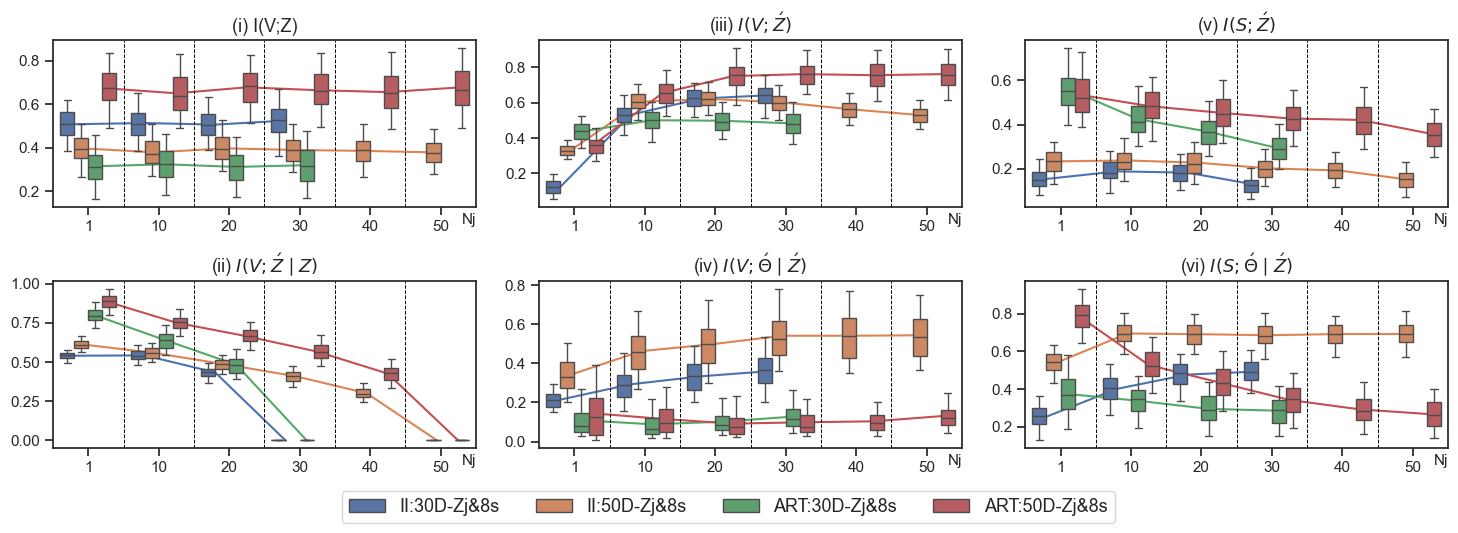

In [14]:
# Initialize variables for plotting
#AnalMItableEval = SZKFC_II_MIs  # Replace with SZKFC_ART_MIs or SZKFC_II_MIs as needed
AnalMItableEval = pd.concat([SZKFC_II_MIs, SZKFC_ART_MIs]).reset_index(drop=True)
AnalMItableEval = AnalMItableEval[AnalMItableEval['Model'].str.contains('8s')]
AnalMItableEval['Values'] = AnalMItableEval.groupby('Metrics')['Values'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Calculate global minimum and maximum values for setting y-axis limits
global_min = AnalMItableEval['Values'].min()
global_max = AnalMItableEval['Values'].max()

# Create a 2x3 subplot layout with specific figure size
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust space between plots

legend_handles = []  # List to collect legend handles

# Iterate through each unique metric and create corresponding plots
for i, metric in enumerate(AnalMItableEval['Metrics'].unique()):
    ax = axes[i % 2, i // 2]  # Determine the subplot position
    metric_data = AnalMItableEval[AnalMItableEval['Metrics'] == metric]

    # Prepare data for plotting
    all_nj_values = np.sort(metric_data['Nj'].unique())
    position_dict = {nj: pos for pos, nj in enumerate(all_nj_values)}

    xmove = -0.2
    for j, model in enumerate(metric_data['Model'].unique()):
           
        model_data = metric_data[metric_data['Model'] == model]
        mean_values = model_data.groupby('Nj')['Values'].mean().reindex(all_nj_values)

        # Line plot for central tendency (mean) for each model
        ax.plot([position_dict[nj] + xmove for nj in mean_values.index], mean_values, label=None)
        xmove += 0.15

    
    for line_pos in [0.5, 1.5, 2.5, 3.5, 4.5]:
        ax.axvline(x=line_pos, color='black', linestyle='--', linewidth=0.7)
    
    # Box plot overlay and extract legend handles
    bplot = sns.boxplot(data=metric_data, x='Nj', y='Values', hue='Model', ax=ax, showfliers=False, whis=[5, 95])
    if i == 0:
        legend_handles = bplot.get_legend_handles_labels()[0]

    ax.set_title(metric, fontsize=13)  # Set subplot titles
    ax.set_ylabel('')  # Optional: set y-label
    ax.set_xlabel('')  # Remove default x-label
    
    # Extend x-axis limits for text space, set custom x-label
    xlim = ax.get_xlim()
    #ax.set_xlim(xlim[0], xlim[1] + 0.1 * (xlim[1] - xlim[0]))
    ax.text(1.0, -0.12, 'Nj', ha='right', va='bottom', fontsize=11, transform=ax.transAxes)

    ax.set_xticks(np.arange(len(all_nj_values)))  # Set custom x-ticks
    ax.set_xticklabels(all_nj_values)  # Set x-tick labels
    ax.legend().set_visible(False)  # Hide individual subplot legends

#plt.tight_layout()
plt.subplots_adjust(bottom=0.2, wspace=0.15, hspace=0.45)  # Adjust subplot parameters for padding

# Create a unified legend for the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 0.06), fontsize=13)

# Save and display the plot
#filename = './EvalResults/Figures/BP_ART_Njs.png' if 'ART' in AnalMItableEval['ModelNj'].values[0] else './EvalResults/Figures/BP_II_Njs.png'
#plt.savefig(filename, bbox_inches='tight')
plt.show()


### Performace by FCs

In [15]:
# Retrieve table names from directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

# Filter tables containing 'MI' in their names
MItableList = [tab for tab in TableList if 'MI_' in tab and 'Nj1_' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI_' in tab]

# Function to extract FC value from filename
def ExtractFC(Filename):
    Match = re.search(r'FC(\d+\.?\d*)', Filename)
    return Match.group(1) if Match else None

# Initialize DataFrames for ART and II MI tables
ARTMItableSet = pd.DataFrame()
IIMItableSet = pd.DataFrame()

# Process and categorize MI tables based on 'ART' or 'II' in their names
for tab in MItableList:
    FC = ExtractFC(tab)
    MItables = pd.read_csv('./EvalResults/Tables/' + tab)
    MItables['FC'] = FC

    if 'ART' in tab:
        ARTMItableSet = pd.concat([ARTMItableSet, MItables], axis=0)
    elif 'II' in tab:
        IIMItableSet = pd.concat([IIMItableSet, MItables], axis=0)


# Process and rename SKZFC models for ART and II MI tables
SZKFC_II_MIs = IIMItableSet[IIMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()
SZKFC_ART_MIs = ARTMItableSet[ARTMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()

SZKFC_ART_MIs['ModelFC'] = SZKFC_ART_MIs['Model'].str[6:] + '_FC' + SZKFC_ART_MIs['FC'].astype('str')
SZKFC_ART_MIs['Model'] = 'ART:'  + SZKFC_ART_MIs['Model'].str[10:12] + 'D-Zj&' + SZKFC_ART_MIs['Model'].str[13:14] + 's'

SZKFC_II_MIs['ModelFC'] = SZKFC_II_MIs['Model'].str[6:] + '_FC' + SZKFC_II_MIs['FC'].astype('str')
SZKFC_II_MIs['Model'] = 'II:' +  SZKFC_II_MIs['Model'].str[9:11] + 'D-Zj&' + SZKFC_II_MIs['Model'].str[12:13] + 's'

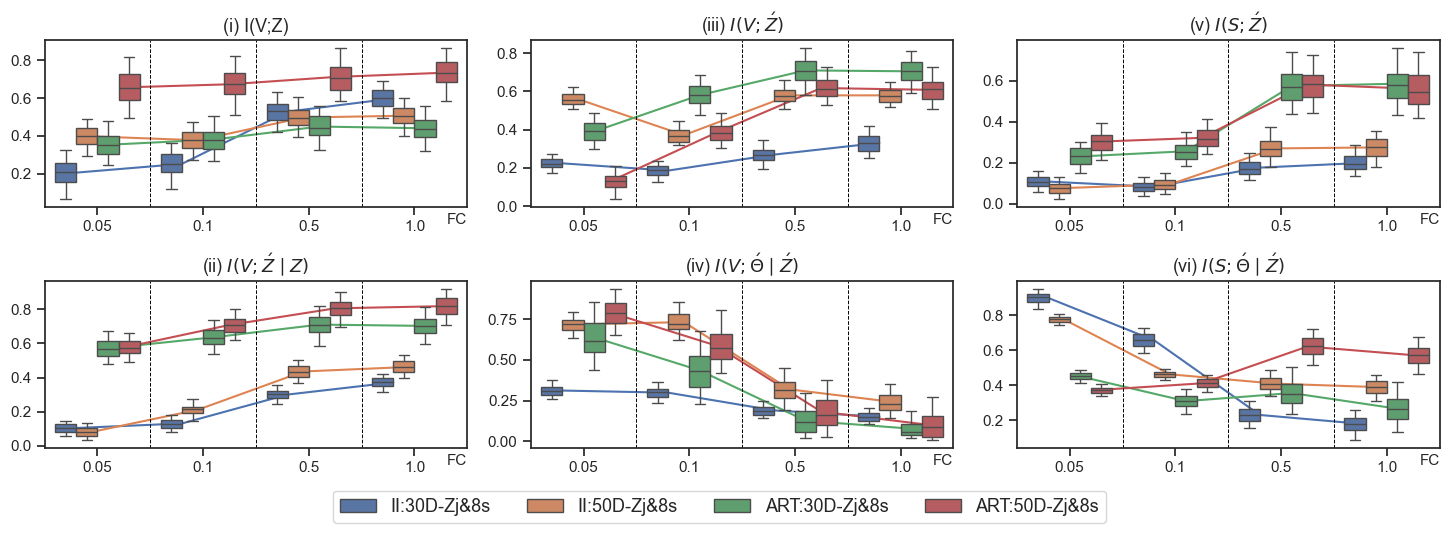

In [16]:
# Initialize variables for plotting
#AnalMItableEval = SZKFC_ART_MIs  # Replace with SZKFC_ART_MIs or SZKFC_II_MIs as needed
AnalMItableEval = pd.concat([SZKFC_II_MIs, SZKFC_ART_MIs]).reset_index(drop=True)
AnalMItableEval = AnalMItableEval[AnalMItableEval['Model'].str.contains('8s')]
AnalMItableEval['Values'] = AnalMItableEval.groupby('Metrics')['Values'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))

# Calculate global minimum and maximum values for setting y-axis limits
global_min = AnalMItableEval['Values'].min()
global_max = AnalMItableEval['Values'].max()

# Create a 2x3 subplot layout with specific figure size
fig, axes = plt.subplots(2, 3, figsize=(18, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # Adjust space between plots

legend_handles = []  # List to collect legend handles

# Iterate through each unique metric and create corresponding plots
for i, metric in enumerate(AnalMItableEval['Metrics'].unique()):
    ax = axes[i % 2, i // 2]  # Determine the subplot position
    metric_data = AnalMItableEval[AnalMItableEval['Metrics'] == metric]

    # Prepare data for plotting
    all_FC_values = np.sort(metric_data['FC'].unique())
    position_dict = {FC: pos for pos, FC in enumerate(all_FC_values)}

    xmove = -0.2
    for j, model in enumerate(metric_data['Model'].unique()):
           
        model_data = metric_data[metric_data['Model'] == model]
        mean_values = model_data.groupby('FC')['Values'].mean().reindex(all_FC_values)

        # Line plot for central tendency (mean) for each model
        ax.plot([position_dict[FC] + xmove for FC in mean_values.index], mean_values, label=None)
        xmove += 0.15

    
    for line_pos in [0.5, 1.5, 2.5, 3.5, 4.5]:
        ax.axvline(x=line_pos, color='black', linestyle='--', linewidth=0.7)
    
    # Box plot overlay and extract legend handles
    bplot = sns.boxplot(data=metric_data, x='FC', y='Values', hue='Model', ax=ax, showfliers=False, whis=[5, 95])
    if i == 0:
        legend_handles = bplot.get_legend_handles_labels()[0]

    ax.set_title(metric, fontsize=13)  # Set subplot titles
    ax.set_ylabel('')  # Optional: set y-label
    ax.set_xlabel('')  # Remove default x-label
    
    # Extend x-axis limits for text space, set custom x-label
    xlim = ax.get_xlim()
    #ax.set_xlim(xlim[0], xlim[1] + 0.1 * (xlim[1] - xlim[0]))
    ax.text(1.0, -0.12, 'FC', ha='right', va='bottom', fontsize=11, transform=ax.transAxes)

    ax.set_xticks(np.arange(len(all_FC_values)))  # Set custom x-ticks
    ax.set_xticklabels(all_FC_values)  # Set x-tick labels
    ax.legend().set_visible(False)  # Hide individual subplot legends

plt.subplots_adjust(bottom=0.2, wspace=0.15, hspace=0.45)  # Adjust subplot parameters for padding

# Create a unified legend for the figure
fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 0.06), fontsize=13)

# Save and display the plot
#filename = './EvalResults/Figures/BP_ART_FCs.png' if 'ART' in AnalMItableEval['ModelFC'].values[0] else './EvalResults/Figures/BP_II_FCs.png'
#plt.savefig(filename, bbox_inches='tight')
plt.show()

## 2D scatter plots
#### Data Aggregation and Normalization for Model Performance Analysis

#### Define lists of table names for different categories and conditions in ART and II

In [17]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800']    

#### Aggregation of Accuracy Tables from Main and Benchmark Datasets

In [18]:
# Retrieve accuracy table names from specific directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

# Filter tables containing 'Acc' and 'Nj1.' in their names from both directories
AcctableList = [tab for tab in TableList if 'Acc' in tab and 'Nj1_' in tab and 'FC1.0' in tab]
BMAcctableList = [tab for tab in BMtableList if 'Acc' in tab and 'Nj1.' in tab]

# Initialize DataFrames for storing accuracy tables from main and benchmark datasets
AcctableSet = pd.DataFrame()
BMAcctableSet = pd.DataFrame()

# Read and concatenate accuracy tables from the main dataset
for tab in AcctableList:
    Acctables = pd.read_csv('./EvalResults/Tables/' + tab)
    AcctableSet = pd.concat([AcctableSet, Acctables], axis=0)

# Read and concatenate accuracy tables from the benchmark dataset
for tab in BMAcctableList:
    Acctables = pd.read_csv('./Benchmarks/EvalResults/Tables/' + tab)
    BMAcctableSet = pd.concat([BMAcctableSet, Acctables], axis=0)

# Combine accuracy tables from both main and benchmark datasets
AcctableSet = pd.concat([AcctableSet, BMAcctableSet])


In [19]:
# Combine various ART and II tab lists for comprehensive analysis
AnalTabList = TabList_ART_800 + TabList_ART_500 + TabList_II_500 + TabList_II_800
# Define the list of metrics for detailed analysis
AnalMetricList = ['(ii) $I(V; \\acute{Z} \\mid Z)$', '(iv) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$', '(vi) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']
# Filter and reset index for Mutual Information (MI) table set based on Analysis Tab List
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Filter and reset index for Accuracy table set based on Analysis Tab List
AnalAcctableSet = AcctableSet[(AcctableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Normalization and preparation of Accuracy table set
AnalAcctableSet['MAPEnorm'] = AnalAcctableSet['MAPEnorm'] / 100
# Select only relevant columns ('Model', 'MeanKldRes', 'MAPEnorm') for analysis
AnalAcctableSet = AnalAcctableSet[['Model', 'MeanKldRes', 'MAPEnorm']].copy()


In [21]:
def Normalization(series):
    # Normalize a numeric series using min-max normalization
    return (series - series.min()) / (series.max() - series.min()) if np.issubdtype(series.dtype, np.number) else series

# Filter the MI table set for models in the Analysis Tab List and reset the index
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
# Group data by 'Model' and 'Metrics', calculate the mean, and reset the index
AnalMItableSet = AnalMItableSet.groupby(['Model', 'Metrics']).mean().reset_index().copy()
# Filter rows where 'Metrics' are in the list of analytical metrics and reset the index
AnalMItableSet = AnalMItableSet[AnalMItableSet['Metrics'].isin(AnalMetricList)].reset_index(drop=True)
# Pivot the table to have 'Model' as rows, 'Metrics' as columns, and 'Values' as cell values
AnalMItableSet = pd.pivot(AnalMItableSet, index='Model', columns='Metrics', values='Values').reset_index().copy()
# Rename columns to more descriptive names
AnalMItableSet.columns = ['Model', 'Disentanglement', 'InfoGain'+'$\\Theta$', 'Controllability']
# Apply normalization to each column of the table
NormAnalMItableSet = AnalMItableSet.apply(Normalization)
# Merge normalized MI table with Accuracy table and sort by 'Model'
AnalAccMItable = pd.merge(AnalAcctableSet, AnalMItableSet, on='Model', how='inner').sort_values('Model').reset_index(drop=True)

# Filtering the DataFrame based on 'Model' values for ConVAE, SKZ, and others
ConVAEData = AnalAccMItable[AnalAccMItable['Model'].str.contains('ConVAE')]
SKZData = AnalAccMItable[AnalAccMItable['Model'].str.contains('SKZ')]
# For 'others', assuming not ConVAE or SKZ
OtherData = AnalAccMItable[~AnalAccMItable['Model'].str.contains('ConVAE|SKZ')]

# Calculating mean values for each group
MeanConVAE = ConVAEData[['InfoGain$\\Theta$', 'Disentanglement', 'Controllability']].mean()
MeanSKZ = SKZData[['InfoGain$\\Theta$', 'Disentanglement', 'Controllability']].mean()
MeanOtherData = OtherData[['InfoGain$\\Theta$', 'Disentanglement', 'Controllability']].mean()

In [22]:
# Define benchmark lists for ART and II categories
ARTBenchList = ['BaseVAE_ART_30', 'TCVAE_ART_30', 'FACVAE_ART_30', 'BaseVAE_ART_50', 'TCVAE_ART_50', 'FACVAE_ART_50']
IIBenchList = ['BaseVAE_II_30', 'TCVAE_II_30', 'FACVAE_II_30', 'BaseVAE_II_50', 'TCVAE_II_50', 'FACVAE_II_50']

# Combine various ART and II tab lists including benchmarks for comprehensive analysis
AnalTabList = TabList_ART_800 + TabList_ART_500 + TabList_II_500 + TabList_II_800 + ARTBenchList + IIBenchList

# Define metrics for analysis
AnalMetricList = ['(i) I(V;Z)', '(ii) $I(V; \\acute{Z} \\mid Z)$', '(iii) $I(V;\\acute{Z})$', 
                  '(iv) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$', '(v) $I(S;\\acute{Z})$', 
                  '(vi) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']

# Filter MI and Accuracy table sets for models in the Analysis Tab List and reset the index
AnalMItableSet = MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)
AnalAcctableSet = AcctableSet[(AcctableSet['Model'].isin(AnalTabList))].reset_index(drop=True)

# Normalization and preparation of Accuracy table set
AnalAcctableSet['MAPEnorm'] = AnalAcctableSet['MAPEnorm'] / 100
AnalAcctableSet = AnalAcctableSet[['Model', 'MeanKldRes', 'MAPEnorm']].copy()

# Group, filter, and pivot the MI table set for analysis
AnalMItableSet = AnalMItableSet.groupby(['Model', 'Metrics']).mean().reset_index().copy()
AnalMItableSet = AnalMItableSet[AnalMItableSet['Metrics'].isin(AnalMetricList)].reset_index(drop=True)
AnalMItableSet = pd.pivot(AnalMItableSet, index='Model', columns='Metrics', values='Values').reset_index().copy()

# Apply normalization to the MI table set
NormAnalMItableSet = AnalMItableSet.apply(Normalization)

# Merge normalized MI table set with Accuracy table set, sort by 'Model', and reset index
AnalAccMItable = pd.merge(AnalAcctableSet, AnalMItableSet, on='Model', how='inner').sort_values('Model').reset_index(drop=True)


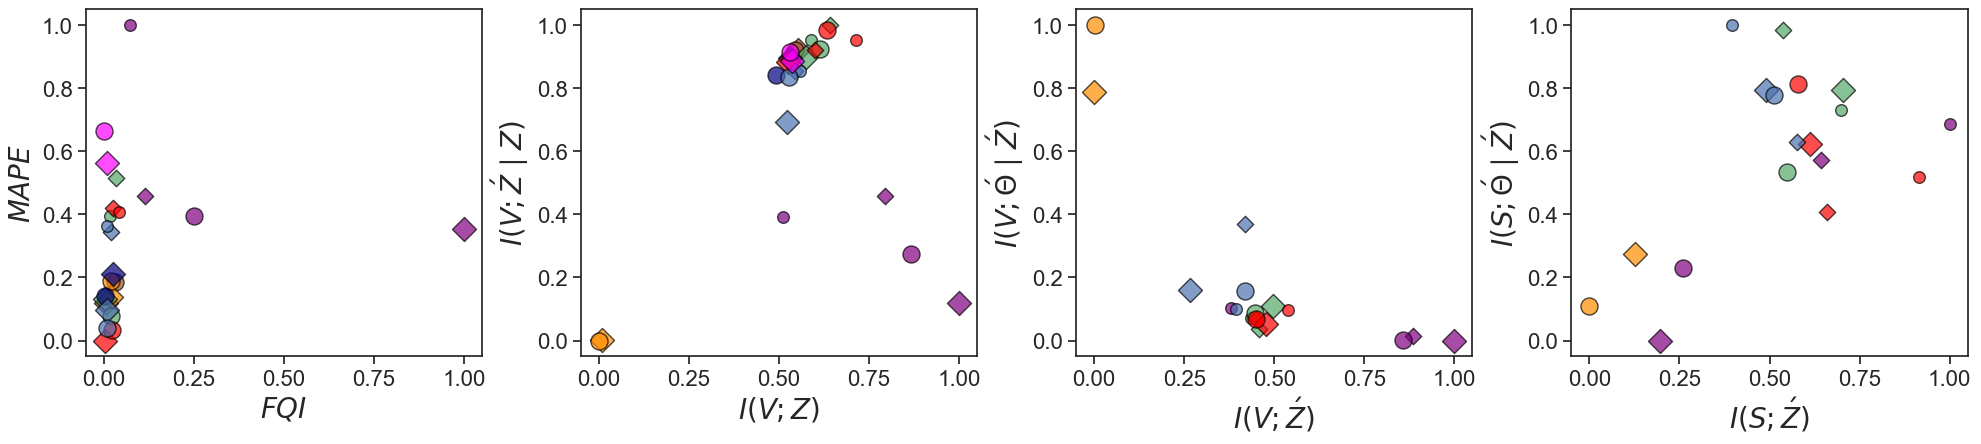

In [24]:
# Filter data for 'ART' models before plotting
data_subset = AnalAccMItable[AnalAccMItable['Model'].str.contains('ART')]
#data_subset = AnalAccMItable[AnalAccMItable['Model'].str.contains('II')]
data_subset = data_subset.rename(columns={'(i) I(V;Z)' : '(i) $I(V;Z)$'})

def normalize(column):
    max_value = column.max()
    min_value = column.min()
    return (column - min_value) / (max_value - min_value)

# Apply normalization to each column, skipping 'Model' column and handling NaN values correctly
# Filtering rows in 'Model' column that contain the specified model
for column in data_subset.columns[1:]:  # Skipping the 'Model' column
    min_val = data_subset[column].min()
    max_val = data_subset[column].max()
    # Handling the situation where the denominator would be zero
    if max_val - min_val > 0:
        data_subset.loc[:, column] = data_subset[column].apply(
            lambda x: (x - min_val) / (max_val - min_val) if pd.notnull(x) else np.nan)
    else:
        # Handling the case where all values are the same (e.g., set all values to 0)
        data_subset.loc[:, column] = 0


# Create a 1x4 subplot structure
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# Define data columns for x and y axes. Adjust these as per your dataset
data_columns = ['$FQI$', '$MAPE$', '(i) $I(V;Z)$', '(ii) $I(V; \\acute{Z} \\mid Z)$', 
                '(iii) $I(V;\\acute{Z})$', '(iv) $I(V;\\acute{\\Theta} \\mid \\acute{Z})$', 
                '(v) $I(S;\\acute{Z})$', '(vi) $I(S;\\acute{\\Theta} \\mid \\acute{Z})$']
data_subset = data_subset.rename(columns={'MeanKldRes':'$FQI$', 'MAPEnorm':'$MAPE$'})

# This regex captures up to two groups of digits, allowing for models with one or two integers
extracted_cols = data_subset['Model'].str.extract(r'_(\d+)_?(\d+)?')

# Assign extracted values to new columns, converting them to numeric and handling missing values
data_subset['Nj'] = pd.to_numeric(extracted_cols[0], errors='coerce')
data_subset['Comp'] = pd.to_numeric(extracted_cols[1], errors='coerce').fillna(0)  # Fill NaNs with 0 if second integer is absent


# Initialize variables for custom legend creation
markers = []
colors = []
labels = []
sizes = []
ColMod = {}
ModCol = {}
MarkSig={}
unique_colors = {}
unique_markers = set()

# Iterate over each subplot for different data columns
for subplot_col in range(4):  # Loop over columns for different data columns
    ax = axs[subplot_col]
    
    # Select x and y columns based on subplot_col
    x_column = data_columns[2 * subplot_col]
    y_column = data_columns[2 * subplot_col + 1]

    # Plot each point in the subset
    for i, row in data_subset.iterrows():
        # Determine marker style, color, and size based on the 'Model' value
        # Determine the marker style based on the 'Model' value
        if 30 == row['Nj']:
            marker = 'D'  # Use '*' for models containing 'II'
            MarkSig[marker] = 'Nj=30'
            if 'D' not in markers:
                markers.append('D')
                labels.append('30')
        elif 50 == row['Nj']:
            marker = 'o'  # Use 'o' for models containing 'ART'
            MarkSig[marker] = 'Nj=50'
            if 'o' not in markers:
                markers.append('o')
                labels.append('50')

        
       # Adjust marker size based on 'Model' value
        if 500 == row['Comp']:
            marker_size = 70
        elif 800 == row['Comp']:
            marker_size = 150
        elif 0 == row['Comp']:
            marker_size = 150
            
        
        # Determine the color based on the 'Model' value
        if 'ConVAE' in row['Model'] :
            color = 'darkorange'  # Use gray for models containing 'ConVAE' or 'SKZ'
            ColMod[color] = 'ConVAE'
            ModCol['ConVAE'] = color
            if 'darkorange' not in colors:
                colors.append('darkorange')
    
        elif 'SKZ_' in row['Model']:
            color = 'purple'  # Use green for other models
            ColMod[color] = 'SKZ'
            ModCol['SKZ'] = color
            if 'purple' not in colors:
                colors.append('purple')
        
        elif 'SKZFC' in row['Model']:
            color = 'red'  # Use green for other models
            ColMod[color] = 'SKZFC'
            ModCol['SKZFC'] = color
            if 'red' not in colors:
                colors.append('red')
        
        elif 'FACFC' in row['Model']:
            color = 'g'  # Use green for other models
            ColMod[color] = 'FACFC'
            ModCol['FACFC'] = color
            if 'g' not in colors:
                colors.append('g')
        
        elif 'TCMIDKZFC' in row['Model']:
            color = 'b'  # Use green for other models
            ColMod[color] = 'TCMIDKZFC'
            ModCol['TCMIDKZFC'] = color
            if 'b' not in colors:
                colors.append('b')
    
        elif 'BaseVAE' in row['Model']:
            color = 'sienna'  # Use green for other models
            ColMod[color] = 'BaseVAE'
            ModCol['BaseVAE'] = color
            if 'sienna' not in colors:
                colors.append('sienna')
    
        elif 'TCVAE' in row['Model']:
            color = 'magenta'  # Use green for other models
            ColMod[color] = 'TCVAE'
            ModCol['TCVAE'] = color
            if 'magenta' not in colors:
                colors.append('magenta')
    
        elif 'FACVAE' in row['Model']:
            color = 'navy'  # Use green for other models
            ColMod[color] = 'FACVAE'
            ModCol['FACVAE'] = color
            if 'navy' not in colors:
                colors.append('navy')

        ax.scatter(row[x_column], row[y_column], c=color, marker=marker, s=marker_size, alpha=0.7, edgecolors='black')
        unique_markers.add((marker, MarkSig.get(marker, '')))  # Keep track of marker and its label
        unique_colors[color] = ColMod.get(color, '')  # Keep track of color and its label
        
    # Set axis labels with adjusted column names (remove prefix for readability)
    ax.set_xlabel(re.sub(r'\(\w+\)\s*', '', x_column), fontsize=20)
    ax.set_ylabel(re.sub(r'\(\w+\)\s*', '', y_column), fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=16)


plt.tight_layout()


# Create custom legend elements
legend_elements = []

for marker, label in unique_markers:
    legend_elements.append(Line2D([0], [0], marker=marker, color='w', label=label, markersize=12, markerfacecolor='black'))
for color, label in unique_colors.items():
    legend_elements.append(Line2D([0], [0], marker='', color=color, label=label, markersize=12, markerfacecolor=color))

plt.subplots_adjust(bottom=0.27, wspace=0.25, hspace=0.0)

# Show plot

if 'ART' in data_subset['Model'].iloc[0]:
    plt.savefig('./EvalResults/Figures/CrossMetrics'+ 'ART' +'.png')
elif 'II' in data_subset['Model'].iloc[0]:
    # Create and display the unified legend at the bottom of the figure
    fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.0), ncol=10, fontsize=17)
    plt.savefig('./EvalResults/Figures/CrossMetrics'+ 'II' +'.png')
 
plt.show()

### HeatMap

In [25]:
from itertools import product

NJ_pattern = r'Nj(\d+)'
FC_pattern = r'FC([0-9]*\.[0-9]+|[0-9]+)'


# Retrieve and filter Mutual Information (MI) table names from directories
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI_' in tab and '_SKZFC_' in tab and '_50_800' in tab ]

# Initialize DataFrames and concatenate tables for MI datasets
MItableSet = pd.DataFrame()
for tab in MItableList:
    MItables = pd.read_csv('./EvalResults/Tables/' + tab)
    Nj = re.search(NJ_pattern, tab)
    FC = re.search(FC_pattern, tab)
    MItables['Nj'] = Nj.group(1) if Nj else None
    MItables['FC'] =FC.group(1) if FC else None

    MItableSet = pd.concat([MItableSet, MItables], axis=0)



# Retrieve accuracy table names from specific directories
AcctableList = [tab for tab in TableList if 'AccKLD' in tab and '_SKZFC_' in tab and '_50_800' in tab]

# Initialize DataFrames for storing accuracy tables from main and benchmark datasets
AcctableSet = pd.DataFrame()
# Read and concatenate accuracy tables from the main dataset
for tab in AcctableList:
    Acctables = pd.read_csv('./EvalResults/Tables/' + tab)
    AcctableSet = pd.concat([AcctableSet, Acctables], axis=0)
AcctableSetLong = pd.melt(AcctableSet, id_vars=['Model'], value_vars=['MeanKldRes', 'MAPEnorm'])
AcctableSetLong = AcctableSetLong.rename(columns={'variable':'Metrics', 'value':'Values'})
MetricRename = {'MeanKldRes' : '(viii) FQI', 'MAPEnorm' :'(vii) MAPE' }
AcctableSetLong['Metrics'] = AcctableSetLong['Metrics'].map(MetricRename)


AccMItab = pd.concat([MItableSet, AcctableSetLong]).reset_index(drop=True)


Comb = product(MItableSet['Metrics'].unique(), MItableSet['Model'].unique())
HeatmapData = {}

for metric, model in Comb:
    if model not in HeatmapData:
        HeatmapData[model] = {}
    LongTab = MItableSet[(MItableSet['Model'] == model) & (MItableSet['Metrics'] == metric)][['Values','Nj','FC']]
    HeatmapData[model][metric] = LongTab.pivot_table(index='Nj', columns='FC', values='Values')

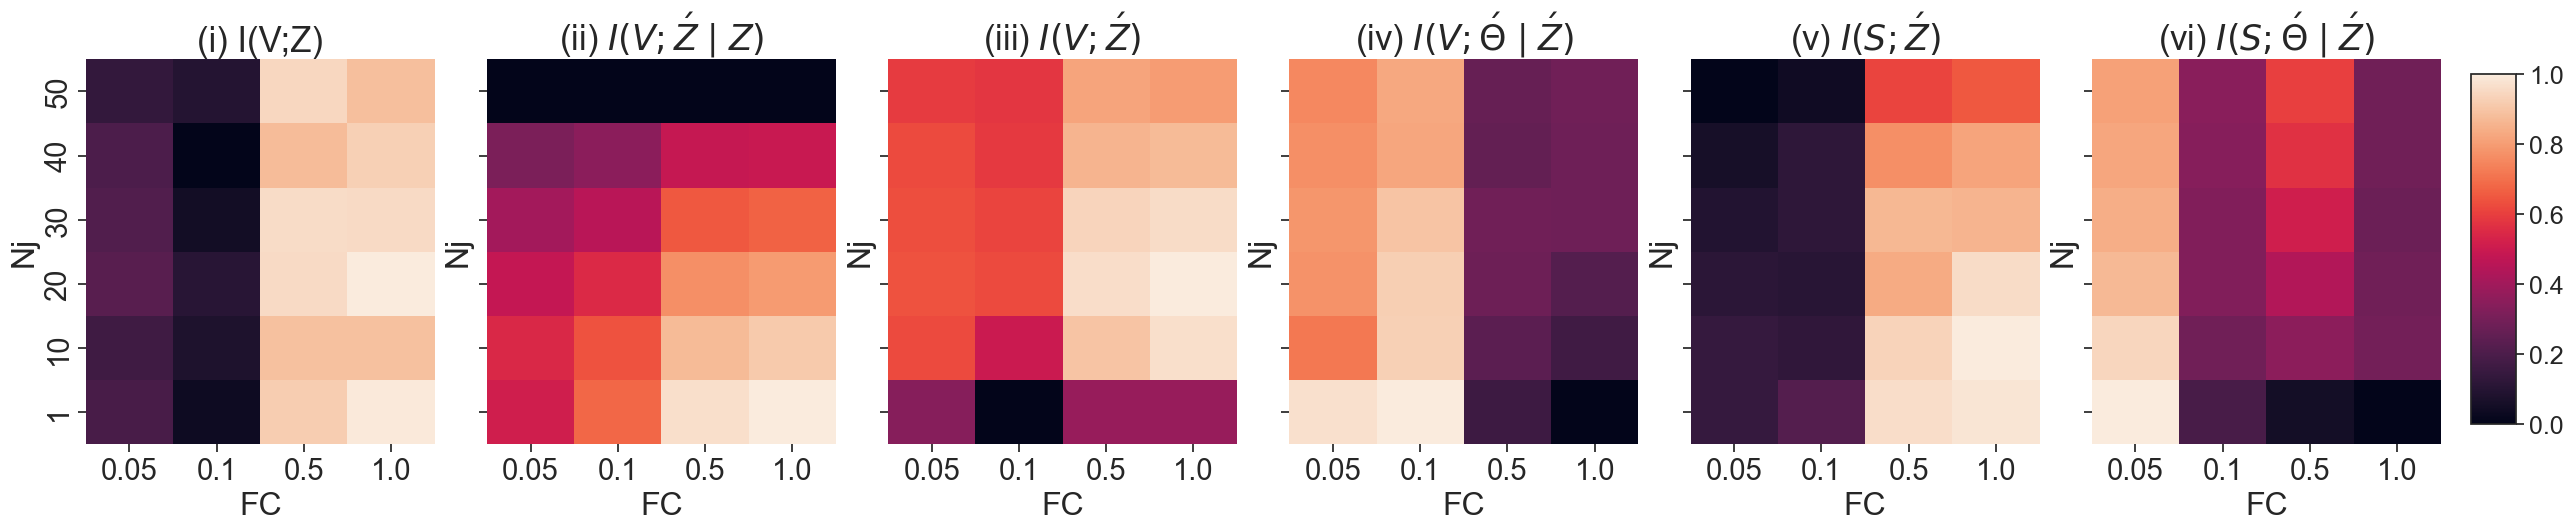

In [27]:
# Select a specific model. Replace 'chosen_model' with your model's name if needed.
chosen_model = 'SKZFC_II_50_800' #'SKZFC_ART_50_800' 'SKZFC_II_50_800'
metrics = HeatmapData[chosen_model]

# Adjusted font sizes
title_fontsize = 25
label_fontsize = 23
tick_labelsize = 21  # New variable for tick label size
cbar_tick_labelsize = 18  # Size for tick labels on the color bar

# Assuming a 1x6 subplot layout. Adjust as needed.
num_metrics = len(metrics)
fig, axs = plt.subplots(1, num_metrics, figsize=(num_metrics*5, 5), sharex='col', sharey='row')

# Ensure axs is iterable when there's only one metric
if num_metrics == 1:
    axs = [axs]

# Plot the heatmaps for each metric of the chosen model
for j, (metric, df) in enumerate(metrics.items()):
    ax = axs[j]
    sns.heatmap(df, ax=ax, cbar=False)  # Use the same color map for consistency
    ax.set_title(metric, fontsize=title_fontsize)  # Set title with larger font size
    ax.set_xlabel('FC', fontsize=label_fontsize)  # Set x-axis label with larger font size
    ax.set_ylabel('Nj', fontsize=label_fontsize)  # Set y-axis label with larger font size
    ax.tick_params(axis='both', which='major', labelsize=tick_labelsize)
    ax.invert_yaxis()

# Adjust the layout and add a single color bar
fig.subplots_adjust(right=0.91)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # Adjusted color bar position
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.ax.tick_params(labelsize=cbar_tick_labelsize)

# Adjust subplot parameters for a cleaner layout
plt.subplots_adjust(wspace=0.15, hspace=0.0)  # Adjust spacing between subplots


if 'ART' in chosen_model:
    plt.savefig('./EvalResults/Figures/HeatMap'+ 'ART' +'.png', bbox_inches='tight')
elif 'II' in chosen_model:
    plt.savefig('./EvalResults/Figures/HeatMap'+ 'II' +'.png', bbox_inches='tight')


# Show the plot
plt.show()

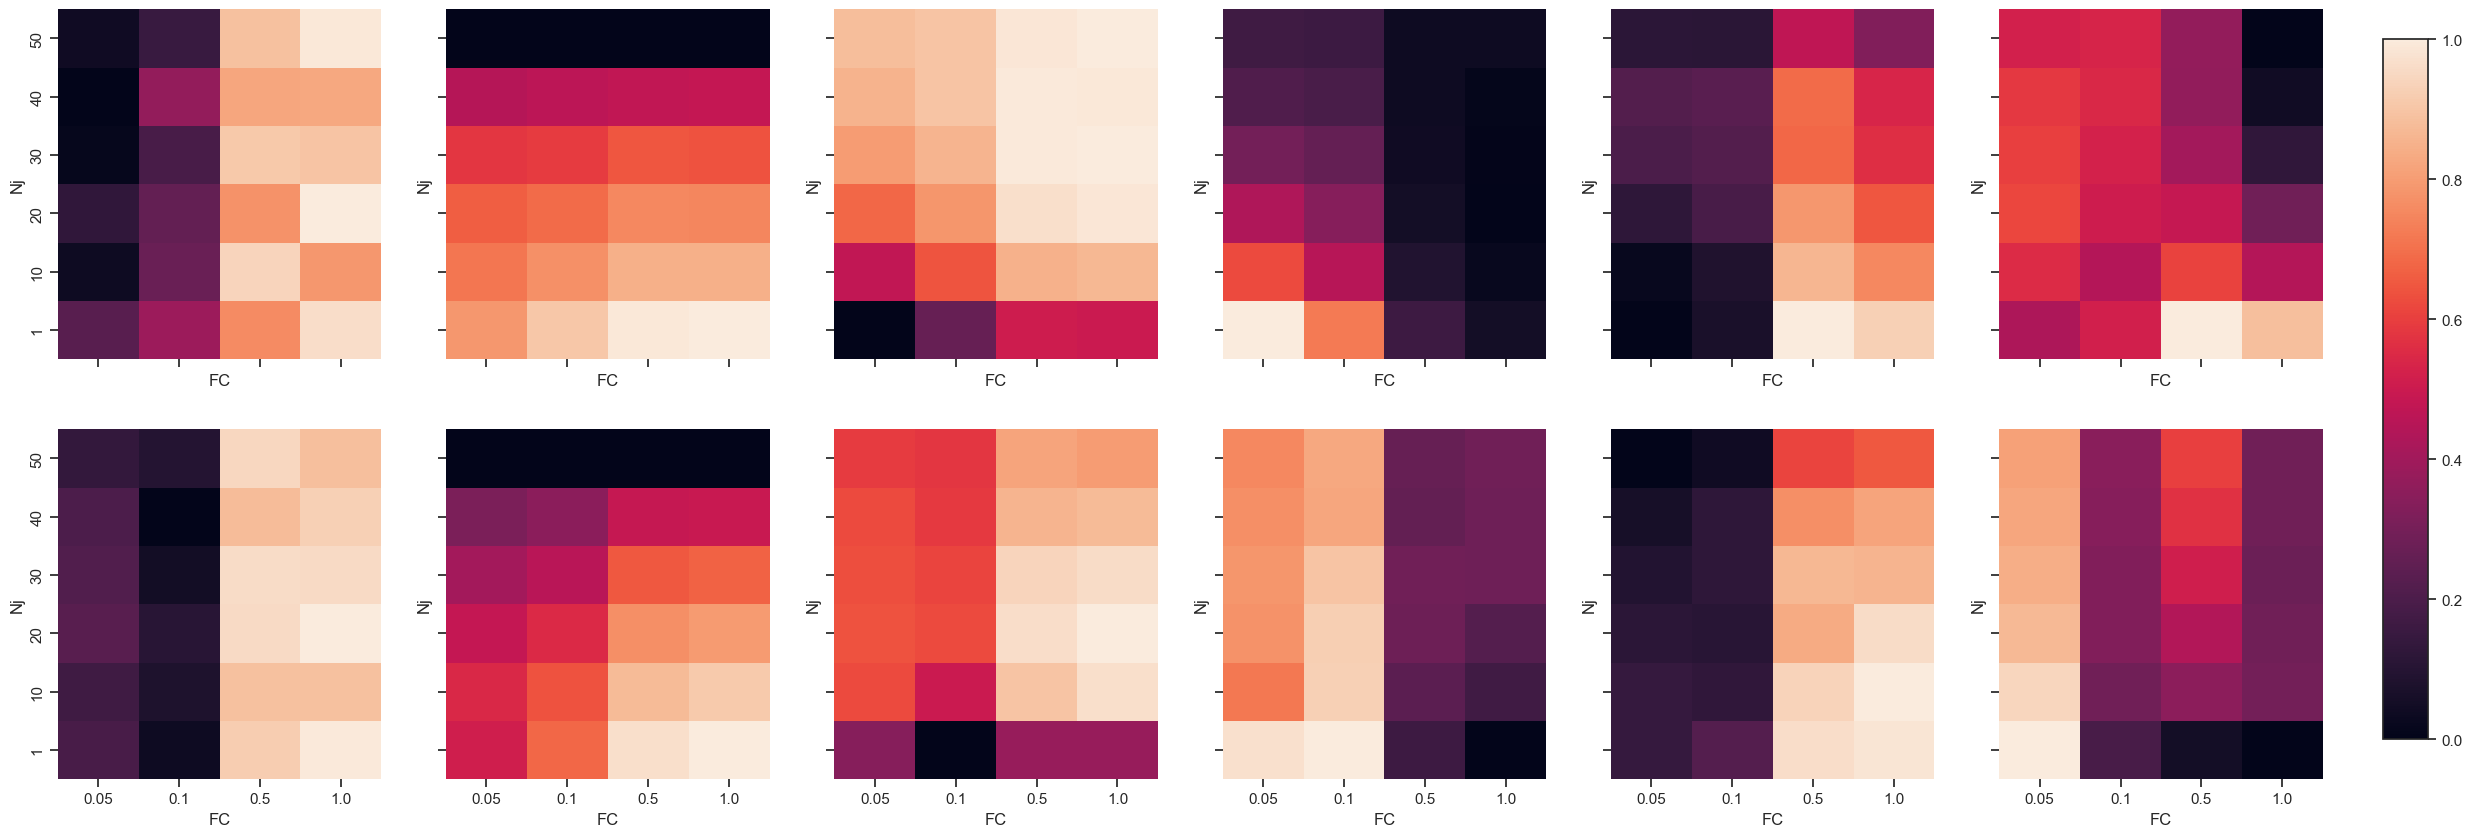

In [28]:
# Function to normalize a DataFrame using Min-Max normalization
def normalize_dataframe(df):
    # Apply Min-Max normalization
    return (df - df.min().min()) / (df.max().max() - df.min().min())

# Normalize each DataFrame within HeatmapData
for model, metrics in HeatmapData.items():
    for metric in metrics:
        HeatmapData[model][metric] = normalize_dataframe(HeatmapData[model][metric])

# Calculate the number of unique models and metrics for subplot dimensions
num_models = len(HeatmapData.keys())
num_metrics = max(len(metrics) for metrics in HeatmapData.values())

# Create a figure and axes for subplots
fig, axs = plt.subplots(num_models, num_metrics, figsize=(num_metrics*5, num_models*5), sharex='col', sharey='row')

# Flatten the axes array for easier iteration if there's more than one subplot
if num_models * num_metrics > 1:
    axs = axs.flatten()

# Plot the heatmaps
for i, (model, metrics) in enumerate(HeatmapData.items()):
    for j, (metric, df) in enumerate(metrics.items()):
        ax = axs[i * num_metrics + j] if num_models * num_metrics > 1 else axs
        sns.heatmap(df, ax=ax, cbar=False)  # No need to specify vmin and vmax after normalization
        ax.invert_yaxis()
        
# Create a single color bar for the entire figure
fig.subplots_adjust(right=0.88)
cbar_ax = fig.add_axes([0.9, 0.15, 0.015, 0.7])  # Position of the color bar
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=0, vmax=1))
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Adjust layout
#plt.tight_layout(rect=[0, 0, 0.9, 1])  # Prevent overlap with the color bar

# Show the plot
plt.show()